# Tackling Overfitting
There are broadly 2 ways in which overfitting can be reduced,
1. Modification in model pipeline: Improving network configuration to solve over-parameterization.
2. Modification in data pipeline: Augmenting the dataset to increase the number of samples.

# Revisiting The Problem Statement And The Baseline Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings

In [2]:
pd.set_option("display.max_columns", None)
sns.set_theme(style = "whitegrid")
warnings.filterwarnings("ignore")
tf.keras.utils.set_random_seed(42)

In [3]:
!tree clothing_dataset_small -d

clothing_dataset_small
├── test
│   ├── dress
│   ├── hat
│   ├── longsleeve
│   ├── outwear
│   ├── pants
│   ├── shirt
│   ├── shoes
│   ├── shorts
│   ├── skirt
│   └── t-shirt
├── train
│   ├── dress
│   ├── hat
│   ├── longsleeve
│   ├── outwear
│   ├── pants
│   ├── shirt
│   ├── shoes
│   ├── shorts
│   ├── skirt
│   └── t-shirt
└── validation
    ├── dress
    ├── hat
    ├── longsleeve
    ├── outwear
    ├── pants
    ├── shirt
    ├── shoes
    ├── shorts
    ├── skirt
    └── t-shirt

34 directories


In [4]:
print("\nLoading training data...")
train_data = tf.keras.utils.image_dataset_from_directory("clothing_dataset_small/train", shuffle = True)

print("\nLoading validation data...")
val_data = tf.keras.utils.image_dataset_from_directory("clothing_dataset_small/validation", shuffle = False)

print("\nLoading testing data...")
test_data = tf.keras.utils.image_dataset_from_directory("clothing_dataset_small/test", shuffle = False)


Loading training data...
Found 3068 files belonging to 10 classes.

Loading validation data...
Found 341 files belonging to 10 classes.

Loading testing data...
Found 372 files belonging to 10 classes.


In [5]:
# data preprocessing stage with resizing and rescaling operations
height = 128
width = 128

data_preprocessing = tf.keras.Sequential(
    name = "data_preprocessing",
    layers = [
        tf.keras.layers.Resizing(height, width), # shape preprocessing
        tf.keras.layers.Rescaling(1.0/ 255) # value preprocessing
    ]
)

# applying preprocessing on train, val and test dataset
train_ds = train_data.map(lambda x, y: (data_preprocessing(x), y), num_parallel_calls = tf.data.AUTOTUNE)
val_ds = val_data.map(lambda x, y: (data_preprocessing(x), y), num_parallel_calls = tf.data.AUTOTUNE)
test_ds = test_data.map(lambda x, y: (data_preprocessing(x), y), num_parallel_calls = tf.data.AUTOTUNE)

In [6]:
# baseline model
num_classes = 10
hidden_size = 256

model = tf.keras.Sequential(
    name = "model_baseline",
    layers = [
        tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu", input_shape = (height, width, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = hidden_size, activation = "relu"),
        tf.keras.layers.Dense(units = num_classes, activation = "softmax")
    ]
)

# plotting the model architecture
# tf.keras.utils.plot_model(model, to_file = "model_baseline.png", show_shapes = True)

model.summary()

Model: "model_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,780,490 (64.01 MB)

 Trainable params: 16,780,490 (64.01 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# compile the model with Cross-Entropy loss and Adam optimizer
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [8]:
# training for 10 epochs
model_fit = model.fit(train_ds, validation_data = val_ds, epochs = 10)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.2728 - loss: 3.0617 - val_accuracy: 0.3871 - val_loss: 1.8616
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.5148 - loss: 1.4922 - val_accuracy: 0.4897 - val_loss: 1.6228
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.6938 - loss: 0.9514 - val_accuracy: 0.5513 - val_loss: 1.4354
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.8455 - loss: 0.5450 - val_accuracy: 0.5718 - val_loss: 1.4182
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.9334 - loss: 0.2823 - val_accuracy: 0.5865 - val_loss: 1.5975
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.9711 - loss: 0.1583 - val_accuracy: 0.5748 - val_loss: 1.6000
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.9914 - loss: 0.0814 - val_accuracy: 0.5953 - val_loss: 1.6630
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9942 - loss: 0.0473 - val_accuracy: 0.5

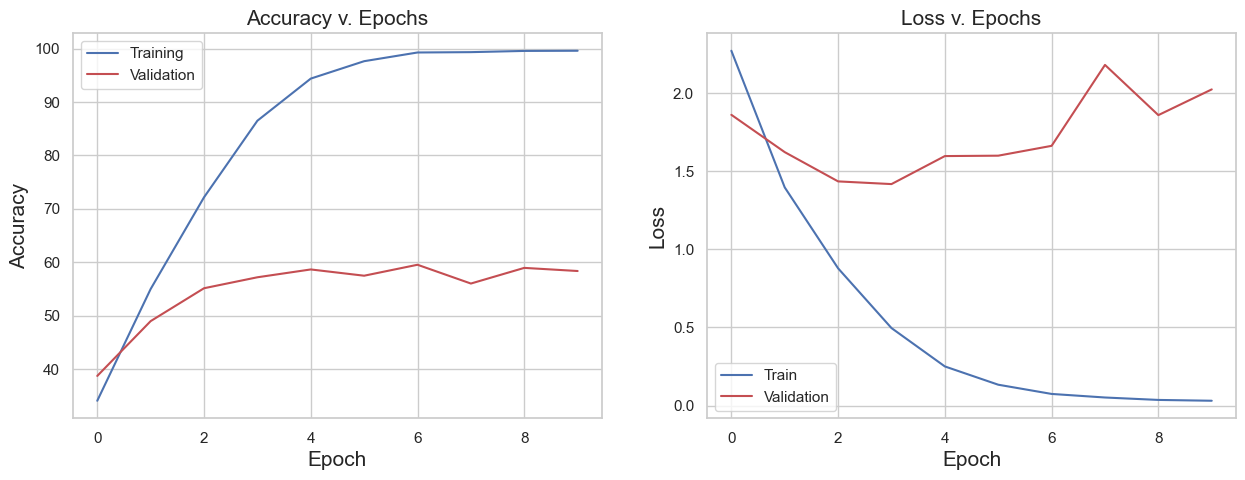

In [9]:
# plotting the training and validation loss and accuracy scores
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
ax = axes.ravel()

# accuracy graph
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["accuracy"]], label = "Training", color = "b")
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["val_accuracy"]], label = "Validation", color = "r")
ax[0].set_title("Accuracy v. Epochs", fontsize = 15)
ax[0].set_ylabel("Accuracy", fontsize = 15)
ax[0].set_xlabel("Epoch", fontsize = 15)
ax[0].legend()

# loss graph
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["loss"], label = "Train", color = "b")
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["val_loss"], label = "Validation", color = "r")
ax[1].set_title("Loss v. Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].set_xlabel("Epoch", fontsize = 15)
ax[1].legend()

plt.show()

In [10]:
# run the model prediction and obtain the probabilities
y_pred = model.predict(test_ds)

# store the list of predicted classes by taking the argmax of the probabilities
predicted_categories = tf.argmax(y_pred, axis = 1)

# extract the list of class names
class_names = test_data.class_names

# create a list of all y's labels by iterating over test dataset
true_categories = tf.concat([y for x, y in test_ds], axis = 0)

# calculate accuracy
from sklearn import metrics

# test accuracy
metrics.accuracy_score(true_categories, predicted_categories) * 100

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


2024-12-29 14:17:14.278844: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


51.075268817204304

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


2024-12-29 14:17:15.024631: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


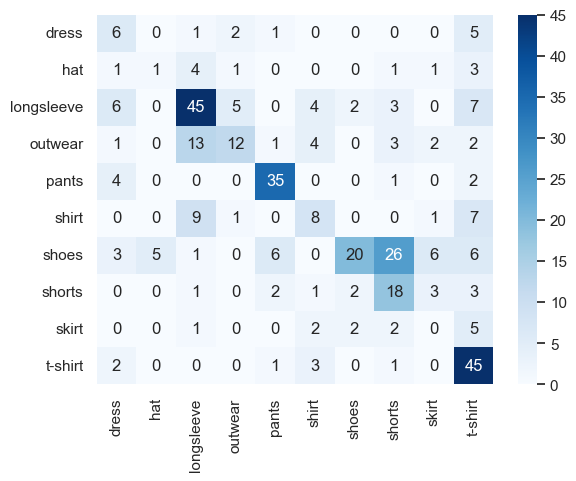

In [11]:
# note that the below logic does not work with shuffled datasets
def ConfusionMatrix(model, ds, label_list):
    # run the model prediction and obtain the probabilities
    y_pred = model.predict(ds)

    # get the list of predicted classes by taking the argmax of the probabilities (y_pred)
    predicted_categories = tf.argmax(y_pred, axis = 1)

    # create a list of all y's labels by iterating over the test dataset
    true_categories = tf.concat([y for x, y in ds], axis = 0)

    # plot a confusion matrix
    cm = metrics.confusion_matrix(true_categories, predicted_categories)
    sns.heatmap(cm, annot = True, xticklabels = label_list, yticklabels = label_list, cmap = "Blues", fmt = "g")
    plt.show()

ConfusionMatrix(model, test_ds, test_data.class_names)

### What is the most apparent issue with the plots above?
Validation accuracy is very low compared to training accuracy. This scenario is better known as overfitting.

### How to solve for overfitting in ML?
Overfitting in Machine Learning occurs when a model learns the training data too well, capturing noise and idiosyncrasies specific to the training set. This leads to poor performance on unseen data (test data).

Key strategies to combat overfitting,
1. Increase training data:
    - More data: The most effective way to combat overfitting is to increase the size and diversity of the training dataset. More data exposes the model to a wider range of examples, forcing it to learn more generalizable patterns.
    - Data augmentation: This technique artificially expands the training dataset by creating variations of existing data points. For images, this could involve rotations, flips, crops and color adjustments. For text, it could involve synonyms, back-translation or adding noise.
2. Reduce model complexity:
    - Smaller models: Using simpler models with fewer parameters can help prevent overfitting. This can involve,
        - Reducing the number of layers in a Neural Network.
        - Decreasing the number of nodes (Neurons) in each layer.
        - Choosing simpler model architecture (e.g., linear models instead of Deep Neural Networks).
    - Feature selection/ engineering: Carefully selecting or engineering relevant features can reduce the complexity of the model and improve its generalization ability.
3. Regularization:
    - L1/ L2 regularization (weight decay): This technique adds a penalty term to the loss function, encouraging the model to have similar weights. This discourages the model from relying too heavily on any single feature and prevents it from becoming overly complex.
    - Dropout: During training, randomly "drop" (set to zero) a fraction of Neurons in each layer. This prevents Neurons from co-adapting too strongly forcing them to learn more robut features.
4. Early stopping:
    - Monitor the model's performance on a validation set during training.
    - Stop training when the performance on the validation set starts to degrade, even though the performance on the training set might still be improving. This prevents the model from overfitting to the training data.

# Tackling Overfitting: Modifications In Model Pipeline
The baseline network has approximately 17 million parameters and just over 3000 images for training. This results in overparameterization of the network making it prone to overfit. One way to tackle this would be to remove some layers from the network. But since it is already a small network, that would badly affect the performance on both training or validation set.

Consider the result of `model.summary()`, observe that close to 99% of the parameters are associated with just one layer, and that is not even the convolutional layer. Although CNN is introduced in the model's architecture, the number of trainable parameters as as result of that is approximately 5000, which is 1000 times less than that of the Dense layers in architecture.

The reason for it is that when the 3D matrix of shape `32x32x32` is flattened into 1D, the number of connections from that layer to Dense layer explodes exponentially (no weight sharing in MLP).

In order to avoid this, the following can be tried,
1. Reduce the 3D volume before the flatten layer by using more convolutions blocks.
2. Replace the flatten layer by `GlobalAveragePooling2D`.

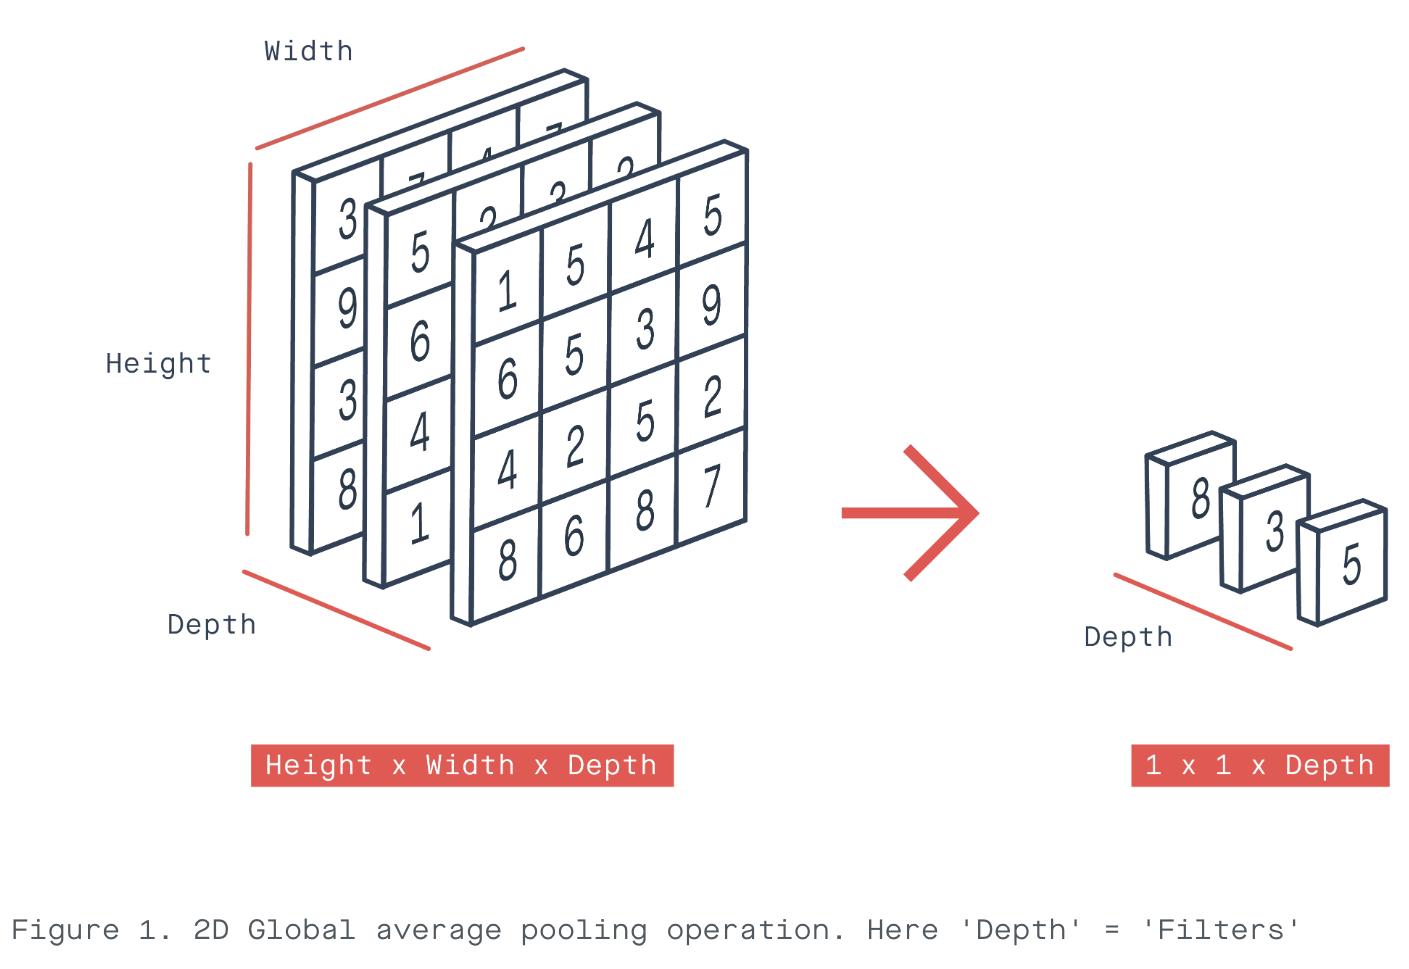

`GlobalAveragePooling2D` takes an input tensor of size `(input width) x (input height) x (input channel)`. It computes the average values across the `(input width) x (input height)` matrix for each of the `(input channels)`.

### Modification 1

In [12]:
num_classes = 10
hidden_size = 256

model = tf.keras.Sequential(
    name = "model_cnn_1",
    layers = [
        tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = "same", activation = "relu", input_shape = (128, 128, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = "same", activation = "relu"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(units = hidden_size, activation = "relu"),
        tf.keras.layers.Dense(units = num_classes, activation = "softmax")
    ]
)

In [13]:
model.summary()

Model: "model_cnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,970 (1.76 MB)

 Trainable params: 460,970 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# compiling
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [15]:
# training for 10 epochs
model_fit = model.fit(train_ds, validation_data = val_ds, epochs = 10)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.2380 - loss: 2.1788 - val_accuracy: 0.2375 - val_loss: 2.1622
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - accuracy: 0.2621 - loss: 2.1177 - val_accuracy: 0.2581 - val_loss: 2.1140
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.3118 - loss: 2.0025 - val_accuracy: 0.3226 - val_loss: 1.9812
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.3612 - loss: 1.8894 - val_accuracy: 0.3402 - val_loss: 1.9131
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.3877 - loss: 1.7858 - val_accuracy: 0.3695 - val_loss: 1.8485
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.4431 - loss: 1.6114 - val_accuracy: 0.4545 - val_loss: 1.6029
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.5171 - loss: 1.4312 - val_accuracy: 0.4985 - val_loss: 1.4479
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.5609 - loss: 1.2990 - val_accu

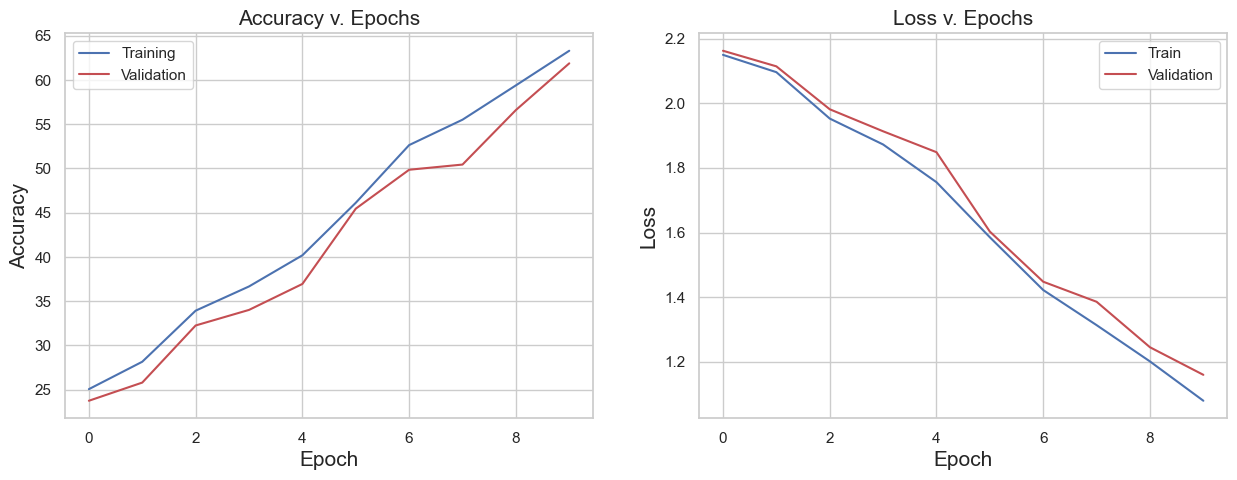

In [16]:
# plotting the training and validation loss and accuracy scores
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
ax = axes.ravel()

# accuracy graph
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["accuracy"]], label = "Training", color = "b")
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["val_accuracy"]], label = "Validation", color = "r")
ax[0].set_title("Accuracy v. Epochs", fontsize = 15)
ax[0].set_ylabel("Accuracy", fontsize = 15)
ax[0].set_xlabel("Epoch", fontsize = 15)
ax[0].legend()

# loss graph
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["loss"], label = "Train", color = "b")
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["val_loss"], label = "Validation", color = "r")
ax[1].set_title("Loss v. Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].set_xlabel("Epoch", fontsize = 15)
ax[1].legend()

plt.show()

In [17]:
# run the model prediction and obtain the probabilities
y_pred = model.predict(test_ds)

# store the list of predicted classes by taking the argmax of the probabilities
predicted_categories = tf.argmax(y_pred, axis = 1)

# extract the list of class names
class_names = test_data.class_names

# create a list of all y's labels by iterating over test dataset
true_categories = tf.concat([y for x, y in test_ds], axis = 0)

# calculate accuracy
from sklearn import metrics

# test accuracy
metrics.accuracy_score(true_categories, predicted_categories) * 100

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


55.64516129032258

With only 2 modifications in the architecture, the model seems to be performing much and the problem of overfitting seems to be vanishing.

Observe that the model's performance seemed to be increasing before it was stopped after 10 epochs leading to underfitting.

But how many more epochs to train for? This obviously cannot be known. But, there are a few references based on which the decision can be made. They are,
1. Early stopping:
    - Monitor validation loss: Continuously evaluate the model's performance on a separate validation dataset.
    - Stop training when the validation loss increases: Once the validation loss starts to increase after a certain number of epochs, it suggests that the model is beginning to overfit the training data.
    - Save the best model: Save the model's weights at the epoch with the lowest validation loss.
2. Plateauing loss:
    - Monitor training loss: Observe the training loss over epochs.
    - Stop training when the loss plateaus: If the training loss stops decreasing significantly, it indicates that the model has reached a point of diminishing returns.
3. Performance metrics:
    - Define relevant metrics: Choose metrics that align with the task at hand (e.g., Accuracy, F1-Score, Precision, Recall).
    - Monitor performance on validation set: Track the chosen metrics on the validation set.
    - Stop training when performance saturates: If the performance on the validation set stops improving, consider stopping the training.
4. Computational resources: If there are limited resources or if there is limited time, a maximum epoch number training time may have to be set.
5. Other constriants:
    - Hyperparameter tuning: The optimal stopping point can also depend on hyperparameter settings. Different parameters have to be experimented with to find the best combination.
    - Data size and complexity: The amount of training data and complexity of the task can influence the appropriate stopping point.

Visualize training process: Plotting the training and validation loss, as well as performance metrics, over epochs can help in visualizing the training process and identify the optimal stopping point.

In [18]:
# compiling
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [19]:
# training for 30 epochs
model_fit = model.fit(train_ds, validation_data = val_ds, epochs = 30)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.6512 - loss: 1.0387 - val_accuracy: 0.5660 - val_loss: 1.1968
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.6769 - loss: 0.9174 - val_accuracy: 0.6129 - val_loss: 1.0425
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.7105 - loss: 0.8325 - val_accuracy: 0.6100 - val_loss: 1.0781
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.7310 - loss: 0.7723 - val_accuracy: 0.6540 - val_loss: 1.0387
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.7361 - loss: 0.7644 - val_accuracy: 0.6686 - val_loss: 0.9789
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.7672 - loss: 0.6590 - val_accuracy: 0.6540 - val_loss: 1.0432
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.7874 - loss: 0.6144 - val_accuracy: 0.7126 - val_loss: 0.8709
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.8117 - loss: 0.5468 - val_accu

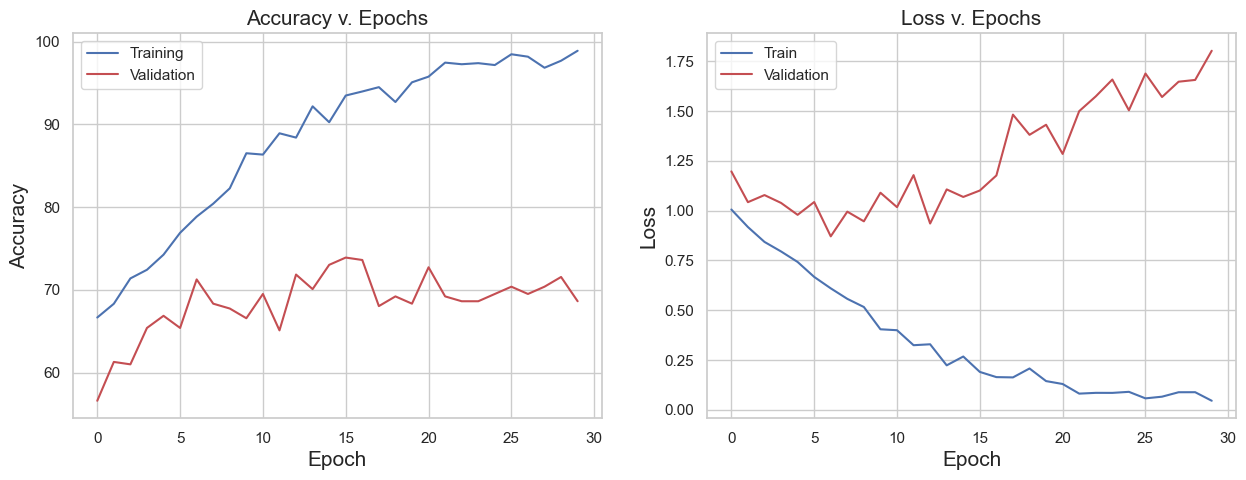

In [20]:
# plotting the training and validation loss and accuracy scores
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
ax = axes.ravel()

# accuracy graph
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["accuracy"]], label = "Training", color = "b")
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["val_accuracy"]], label = "Validation", color = "r")
ax[0].set_title("Accuracy v. Epochs", fontsize = 15)
ax[0].set_ylabel("Accuracy", fontsize = 15)
ax[0].set_xlabel("Epoch", fontsize = 15)
ax[0].legend()

# loss graph
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["loss"], label = "Train", color = "b")
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["val_loss"], label = "Validation", color = "r")
ax[1].set_title("Loss v. Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].set_xlabel("Epoch", fontsize = 15)
ax[1].legend()

plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


2024-12-29 14:27:32.034171: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


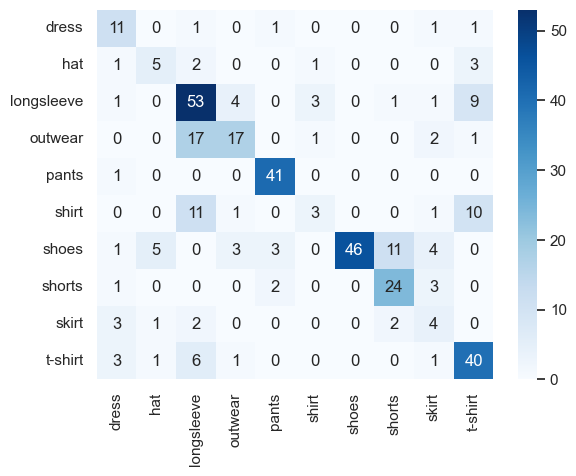

In [21]:
ConfusionMatrix(model, test_ds, test_data.class_names)

In [22]:
# run the model prediction and obtain the probabilities
y_pred = model.predict(test_ds)

# store the list of predicted classes by taking the argmax of the probabilities
predicted_categories = tf.argmax(y_pred, axis = 1)

# extract the list of class names
class_names = test_data.class_names

# create a list of all y's labels by iterating over test dataset
true_categories = tf.concat([y for x, y in test_ds], axis = 0)

# calculate accuracy
from sklearn import metrics

# test accuracy
metrics.accuracy_score(true_categories, predicted_categories) * 100

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


65.59139784946237

A massive improvement in performance is seen on the test dataset. Obviously, many more improvement can be made to the architecture (which will be seen).

### Modification 2
It is known that by adding `Dropout` and `BatchNormalization` helps in regularizing the model, thereby improving the performance on validation dataset. Therefore,
- `BatcNormalization` is added after every `Conv2D` and `Dense` layers.
- `Dropout` is added after `Dense` layers.

What is `Dropout` and why is it required?
- `Dropout` is used to randomly drop the neurons from the network during training.
- `Dropout` helps in reducing overfitting by reducing over-reliability of the network on using certain features to identify in a image. `Dropout` thus encourages the network to utilize all the features to find pattern in an image. This increases the overall generalization of our model, thereby giving good model performance.
- `Dropout` is only used during training and not while evaluating the model. This is because, the capability of every learned Neuron should be used and none of them should be skipped at random during evaluation.

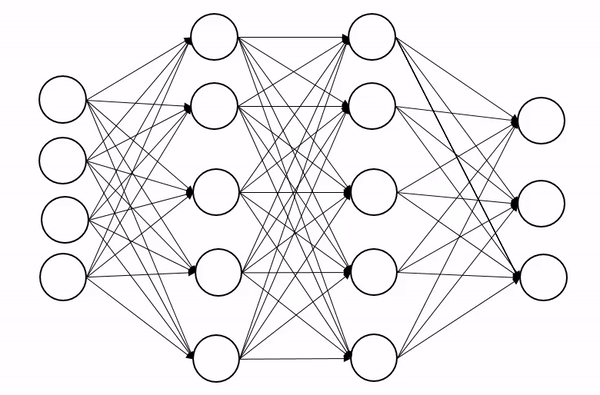

What is `BatchNormalization`?
`BatchNormalization` normalizes the inputs to each layer to a learnt representation likely close to $\mu$ = 0.0, $\sigma$ = 1.0 with respect to every minibatch.

It is a 4 step process,
1. Computing the mean of the mini-batch, $\mu_B^{(k)} = \frac{1}{m} \sum_{i = 1}^{m} x_{B_{i}}^{(k)}$.
2. Computing the variance of the mini-batch, $\sigma_B^{2^{(k)}} = \frac{1}{m} \sum_{i = 1}^{m} (x_{B_{i}}^{(k)} - \mu_B^{(k)})^2$.
3. Normalizing the value, $\hat{x}_B^{(k)} = \frac{(x_{B_{i}}^{(k)} - \mu_B^{(k)})}{\sqrt{\sigma_B^{2^{(k)}} + \epsilon}}$.
4. Scaling and shifting, $y_i = \gamma \hat{x}_B^{(k)} + \beta$.

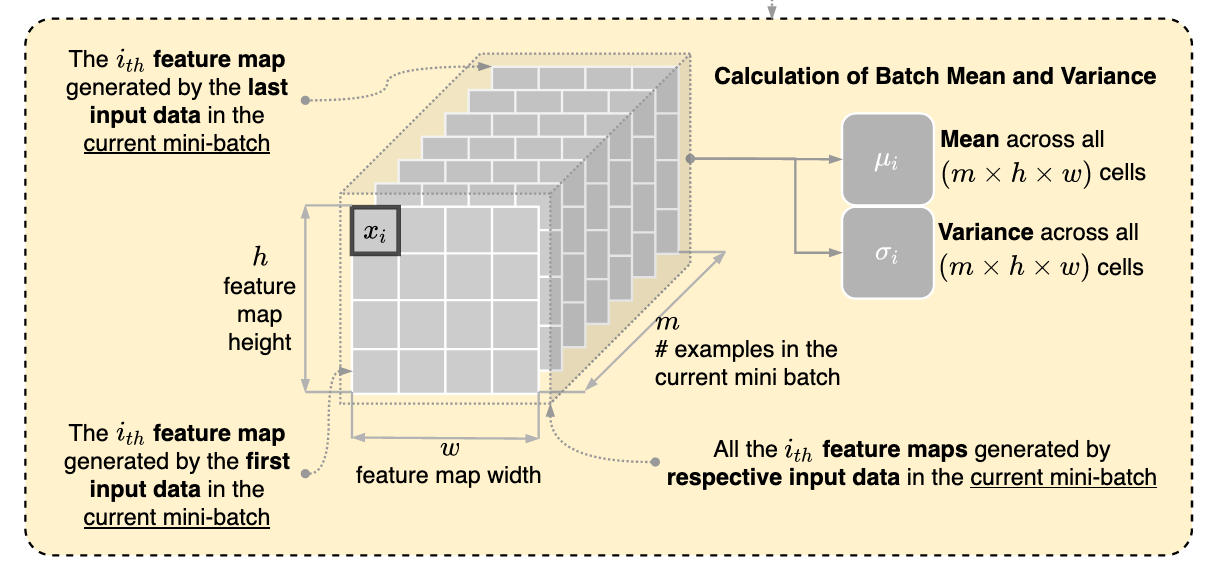

Why `BatchNormalization`?
- In simple terms, just like input normalization, if all the layer inputs are normalized, then the significant outliers are less likely to impact the training process in a negative way. If they do, their impact will be much lower than without using `BatchNormalization`.
- This inturn makes model less sensitive to hyperparameters tuning (e.g., larger learning rates won't effect the training process much).

How does `BatchNormalization` behave during inference?
- During inference, Batch Normalization normalizes new samples based on statistics calculated from the entire training set. This approach produces more robust and accurate estimates compared to using statistics from individual batches during training. Furthermore, computing these statistics on the entire training set is computationally feasible during inference.
- Specifically, the inference step for Batch Normalization can be expressed as, $\hat{x}_B^{(k)} = \frac{(x_{B_{i}}^{(k)} - \mu_B^{(k)})}{\sqrt{\sigma_B^{2^{(k)}} + \epsilon}}$. Where, $x \in X$ and $X$ represents the full training data.

Now that `Dropout` and `BatchNormalization` are understood, where should they be added in the model?
- `Dropout`:
    - Empirical evidence suggests that `Dropout` layers are most effective when placed between Dense layers in a neural network architecture.
    - A common dropout probability for Dense layers is 0.5.
    - `Dropout` layers can also be placed after `MaxPooling` layers, but with lower probabilities (typically between 0.1 and 0.25).
    - These guidelines are generally observed in practice but not strict rules.
- `BatchNormalization`:
    - The original Batch Normalization paper recommended placing `BatchNormalization` layers immediately after Convolutional layers and before non-linear activation functions.
    - Subsequent research has shown that placing `BatchNormalization` layers after non-linear activation functions (such as ReLU) often yields better results.
    - This placement strategy is supported by statistical considerations. Normalizing the output of a Convolutional layer before passing it through a ReLU activation function can lead to a significant portion of the activations being clamped to zero. This effectively alters the distribution of activations, potentially negating the benefits of normalization.

In [23]:
num_classes = 10
hidden_size = 256

model = tf.keras.Sequential(
    name = "model_cnn_2",
    layers = [
        tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = "same", input_shape = (128, 128, 3)),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = "same"),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same"),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = "same"),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = "same"),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(units = hidden_size),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units = num_classes, activation = "softmax")
    ]
)

In [24]:
model.summary()

Model: "model_cnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             

 Total params: 463,978 (1.77 MB)

 Trainable params: 462,474 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [25]:
# compiling
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [26]:
# training for 30 epochs
model_fit = model.fit(train_ds, validation_data = val_ds, epochs = 30)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 238ms/step - accuracy: 0.2053 - loss: 2.9965 - val_accuracy: 0.1437 - val_loss: 2.3119
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.3191 - loss: 2.3368 - val_accuracy: 0.2610 - val_loss: 2.4213
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.4043 - loss: 1.9674 - val_accuracy: 0.2991 - val_loss: 2.5960
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - accuracy: 0.4618 - loss: 1.6978 - val_accuracy: 0.3959 - val_loss: 1.7603
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.5080 - loss: 1.4933 - val_accuracy: 0.4164 - val_loss: 1.6275
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - accuracy: 0.5709 - loss: 1.3094 - val_accuracy: 0.5367 - val_loss: 1.3652
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.6289 - loss: 1.1113 - val_accuracy: 0.5689 - val_loss: 1.2688
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.6690 - loss: 0.9724 - val_accu

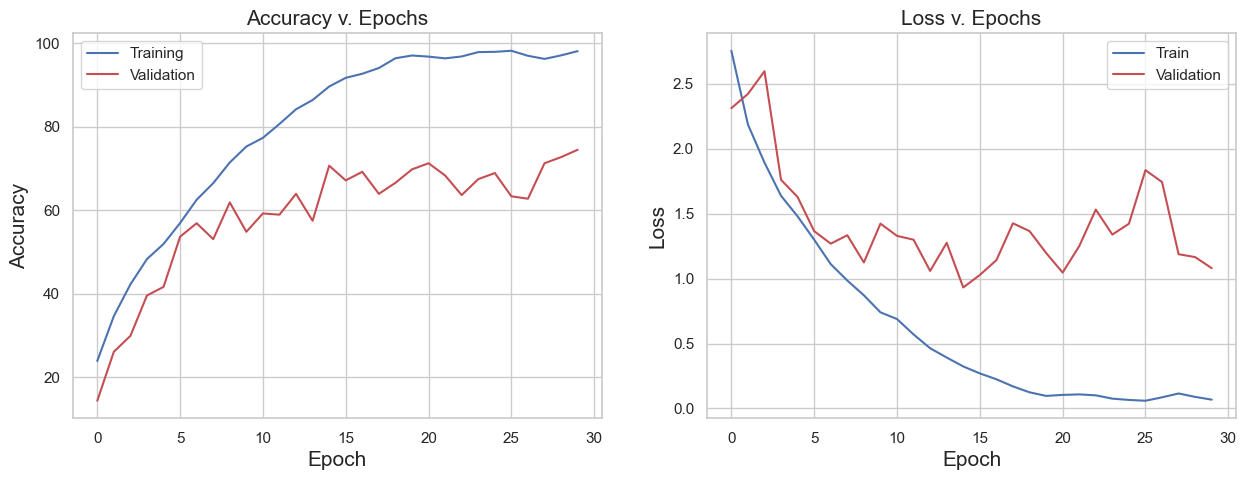

In [27]:
# plotting the training and validation loss and accuracy scores
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
ax = axes.ravel()

# accuracy graph
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["accuracy"]], label = "Training", color = "b")
ax[0].plot(range(0, model_fit.params["epochs"]), [acc * 100 for acc in model_fit.history["val_accuracy"]], label = "Validation", color = "r")
ax[0].set_title("Accuracy v. Epochs", fontsize = 15)
ax[0].set_ylabel("Accuracy", fontsize = 15)
ax[0].set_xlabel("Epoch", fontsize = 15)
ax[0].legend()

# loss graph
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["loss"], label = "Train", color = "b")
ax[1].plot(range(0, model_fit.params["epochs"]), model_fit.history["val_loss"], label = "Validation", color = "r")
ax[1].set_title("Loss v. Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].set_xlabel("Epoch", fontsize = 15)
ax[1].legend()

plt.show()

In [28]:
# run the model prediction and obtain the probabilities
y_pred = model.predict(test_ds)

# store the list of predicted classes by taking the argmax of the probabilities
predicted_categories = tf.argmax(y_pred, axis = 1)

# extract the list of class names
class_names = test_data.class_names

# create a list of all y's labels by iterating over test dataset
true_categories = tf.concat([y for x, y in test_ds], axis = 0)

# calculate accuracy
from sklearn import metrics

# test accuracy
metrics.accuracy_score(true_categories, predicted_categories) * 100

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


73.9247311827957

Observe in the Accuracy v. Epoch plot that the training is not stable. This behavior is an expected one. The reason is that a lot of chaos was added to the training process, for example, `Dropout` switches off 20% of connections randomly at every step.

Note that, every regularization technique induces some form of chaos to the training process.

### How to address this?
A rule of thumb is that, if there is a lot of fluctuation observed it implies that the learning rate is too high.

Learning rate fluctuation during training is a common challenge in neural networks. It indicates that the learning rate might be too high, causing the optimizer to jump around the loss landscape instead of smoothly converging towards a minimum.

Here's how to address learning rate fluctuation:
1. Learning Rate Scheduler:
    - A learning rate scheduler is a technique that dynamically adjusts the learning rate during training.
    - This allows for a larger learning rate initially to explore the loss landscape more broadly, followed by a gradual decrease to fine-tune the weights and achieve convergence.
    - Keras provides built-in learning rate scheduler functions like `ReduceLROnPlateau` which reduces the learning rate when the loss plateaus for a specific number of epochs.
2. Early Stopping:
    - Early stopping is a regularization technique that terminates training when the validation loss stops improving for a predefined number of epochs.
    - This prevents the model from overfitting to the training data and helps to avoid getting stuck in areas of high fluctuation.
    - Keras allows to use the `EarlyStopping` callback during training to monitor validation loss and stop training automatically when the condition is met.

### Modification 3
`ReduceLROnPlateau` is used as Learing Rate Scheduler and `EarlyStopping` is used to stop training once the loss curve plateaus.

In [29]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 5, min_lr = 0.00001),
    tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, min_delta = 0.001, mode = "min")
]

In [30]:
# compiling
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [31]:
# training the model for 100 epochs
model_fit = model.fit(train_ds, validation_data = val_ds, epochs = 100, callbacks = callbacks)

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - accuracy: 0.9659 - loss: 0.0912 - val_accuracy: 0.6686 - val_loss: 1.5567 - learning_rate: 0.0010
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.9742 - loss: 0.0746 - val_accuracy: 0.6921 - val_loss: 1.5181 - learning_rate: 0.0010
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.9792 - loss: 0.0706 - val_accuracy: 0.6393 - val_loss: 1.6176 - learning_rate: 0.0010
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.9741 - loss: 0.0840 - val_accuracy: 0.6804 - val_loss: 1.4702 - learning_rate: 0.0010
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.9701 - loss: 0.0828 - val_accuracy: 0.7185 - val_loss: 1.3607 - learning_rate: 0.0010
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.9853 - loss: 0.0407 - val_accuracy: 0.6657 - val_loss: 1.8100 - learning_rate: 0.0010
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.9819 - l

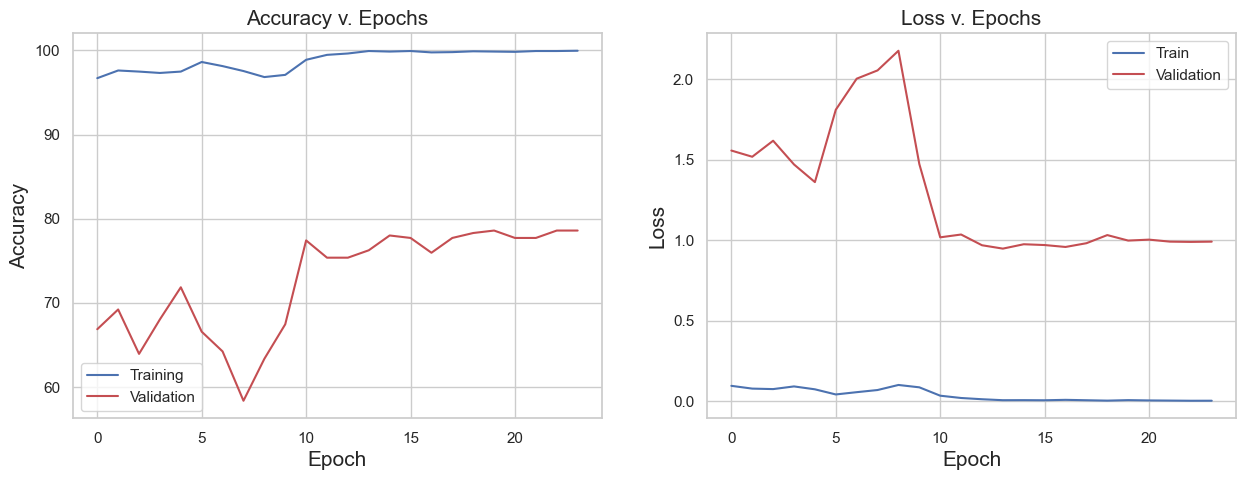

In [32]:
# plotting the training and validation loss and accuracy scores
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
ax = axes.ravel()

# accuracy graph
ax[0].plot(range(0, len(model_fit.history["accuracy"])), [acc * 100 for acc in model_fit.history["accuracy"]], label = "Training", color = "b")
ax[0].plot(range(0, len(model_fit.history["val_accuracy"])), [acc * 100 for acc in model_fit.history["val_accuracy"]], label = "Validation", color = "r")
ax[0].set_title("Accuracy v. Epochs", fontsize = 15)
ax[0].set_ylabel("Accuracy", fontsize = 15)
ax[0].set_xlabel("Epoch", fontsize = 15)
ax[0].legend()

# loss graph
ax[1].plot(range(0, len(model_fit.history["loss"])), model_fit.history["loss"], label = "Train", color = "b")
ax[1].plot(range(0, len(model_fit.history["val_loss"])), model_fit.history["val_loss"], label = "Validation", color = "r")
ax[1].set_title("Loss v. Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].set_xlabel("Epoch", fontsize = 15)
ax[1].legend()

plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


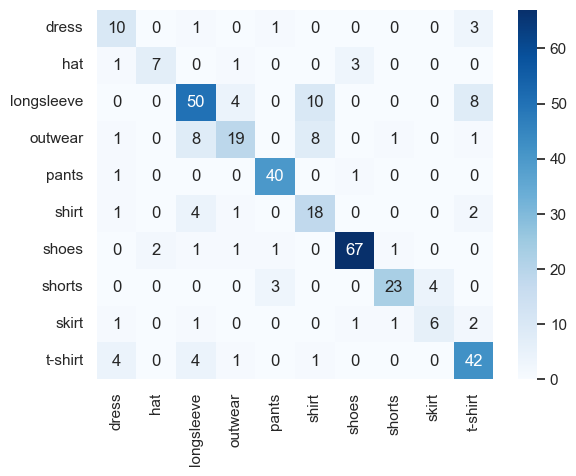

In [33]:
ConfusionMatrix(model, test_ds, test_data.class_names)

In [34]:
# run the model prediction and obtain the probabilities
y_pred = model.predict(test_ds)

# store the list of predicted classes by taking the argmax of the probabilities
predicted_categories = tf.argmax(y_pred, axis = 1)

# extract the list of class names
class_names = test_data.class_names

# create a list of all y's labels by iterating over test dataset
true_categories = tf.concat([y for x, y in test_ds], axis = 0)

# calculate accuracy
from sklearn import metrics

# test accuracy
metrics.accuracy_score(true_categories, predicted_categories) * 100

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


2024-12-29 14:46:38.205515: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75.80645161290323

The above plots suggest that there have been considerable improvements.

### What are the effect of adding L1 or L2 Regularization to the loss function?
L1 Regularization removes some of the features from the model to reduce overfitting. L2 Regulrization reduces the impact of insignificant features, thereby giving a generalizable model. In Keras, regularizers are added in the model definition.

### What is L1 Regularization?
L1 Regularization also known as L1 Norm, combats overfitting by shrinking the parameters towards 0, hence making some features obsolete. L1 Regularization can be interpreted as a form of feature selection. Because, when a feature is assigned with a weight = 0, the significance of the feature is essentially removed. If the input features of the model have weights closer to 0, the L1 Norm would be sparse. A selection of input features would have their weight = 0 and the weights of rest of the features would be non-zero.

Consider the following example to understand L1 Regularization.

Suppose that car prices are to be estimated using ML, and the features that should be used are,
- Brand
- Engine power
- Fuel capacity
- Year of manufacturing
- Cabin volume

When predicting the price of the car, different features will have different influence on the price. For example, it is likely that "Fuel capacity" of the car has lower influence on the price than "Engine power". The L1 Regularization technique would assign "Fuel capacity" with 0 weight and "Engine power" and other influential features on the car price would be assigned non-zero weights. The mathematical representation of L1 Regularization is,

$Loss = \sum_{i = 0}^{n} (y_i - X_i \beta)^2 + \sum_{j = 0}^{m} |\beta_j|$.

L1 Regularization would produce a model that is highly generalized and only uses a subset of input features. This reduces the complexity of the model, which in turn reduces overfitting.

### What is L2 Regularization?
L2 Regularization or L2 Norm, counters overfitting by forcing weights to be small but not 0. In case of the car price prediction example, this means that, the less significant features would still have an influence on the final prediction, but it would be very less.

The regularization term that is added to the loss function when performing L2 Regularization is the sum of square of all the feature weights. This is mathematically expressed as,

$Loss = \sum_{i = 0}^{n} (y_i - X_i \beta)^2 + \sum_{j = 0}^{m} \beta_j^2$.

L2 Regularization returns a non-sparse solution since the weights will be non-zero.

### Modification 4
Adding L2 Regularization to `Conv2D` and `Dense` layers.

In [35]:
num_classes = 10
hidden_size = 256

model = tf.keras.Sequential(
    name = "model_cnn_3",
    layers = [
        tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = "same", input_shape = (128, 128, 3), kernel_regularizer = tf.keras.regularizers.l2(1e-3)),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = "same", kernel_regularizer = tf.keras.regularizers.l2(1e-3)),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", kernel_regularizer = tf.keras.regularizers.l2(1e-3)),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = "same", kernel_regularizer = tf.keras.regularizers.l2(1e-3)),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = "same", kernel_regularizer = tf.keras.regularizers.l2(1e-3)),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(units = hidden_size, kernel_regularizer = tf.keras.regularizers.l2(1e-3)),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units = num_classes, activation = "softmax")
    ]
)

In [36]:
model.summary()

Model: "model_cnn_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 256)            │             

 Total params: 463,978 (1.77 MB)

 Trainable params: 462,474 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [37]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 5, min_lr = 0.00001),
    tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, min_delta = 0.001, mode = "min")
]

# compiling
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

# training the model for 100 epochs
model_fit = model.fit(train_ds, validation_data = val_ds, epochs = 100, callbacks = callbacks)

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 218ms/step - accuracy: 0.1977 - loss: 3.5872 - val_accuracy: 0.2375 - val_loss: 3.0117 - learning_rate: 0.0010
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.3258 - loss: 2.8836 - val_accuracy: 0.2581 - val_loss: 2.9182 - learning_rate: 0.0010
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.3820 - loss: 2.5524 - val_accuracy: 0.3021 - val_loss: 2.9598 - learning_rate: 0.0010
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - accuracy: 0.4723 - loss: 2.2585 - val_accuracy: 0.3783 - val_loss: 2.6212 - learning_rate: 0.0010
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 237ms/step - accuracy: 0.4989 - loss: 2.0688 - val_accuracy: 0.4164 - val_loss: 2.2770 - learning_rate: 0.0010
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.5755 - loss: 1.8738 - val_accuracy: 0.4751 - val_loss: 2.0959 - learning_rate: 0.0010
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.6101 - l

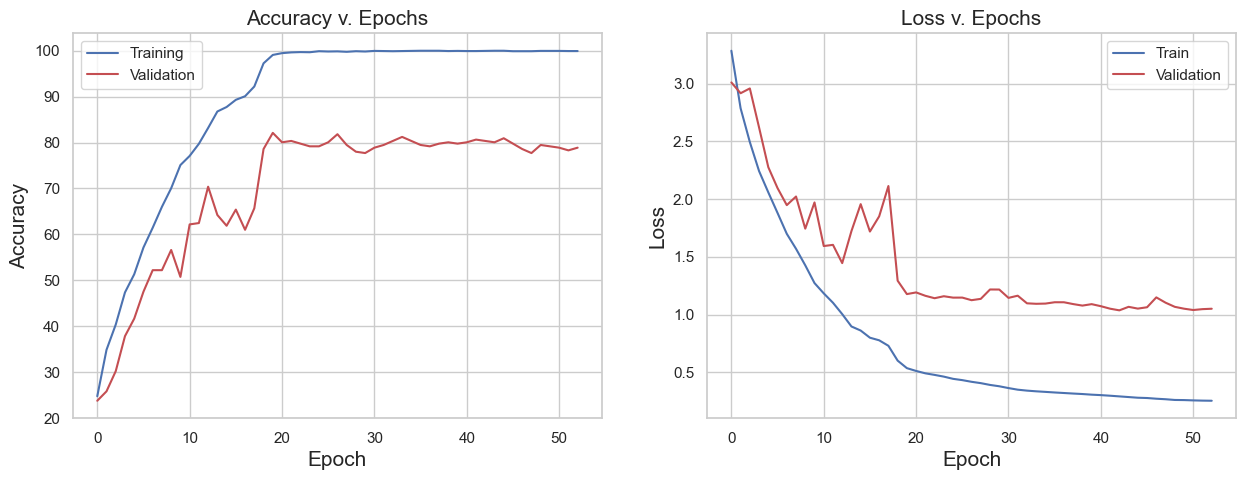

In [38]:
# plotting the training and validation loss and accuracy scores
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
ax = axes.ravel()

# accuracy graph
ax[0].plot(range(0, len(model_fit.history["accuracy"])), [acc * 100 for acc in model_fit.history["accuracy"]], label = "Training", color = "b")
ax[0].plot(range(0, len(model_fit.history["val_accuracy"])), [acc * 100 for acc in model_fit.history["val_accuracy"]], label = "Validation", color = "r")
ax[0].set_title("Accuracy v. Epochs", fontsize = 15)
ax[0].set_ylabel("Accuracy", fontsize = 15)
ax[0].set_xlabel("Epoch", fontsize = 15)
ax[0].legend()

# loss graph
ax[1].plot(range(0, len(model_fit.history["loss"])), model_fit.history["loss"], label = "Train", color = "b")
ax[1].plot(range(0, len(model_fit.history["val_loss"])), model_fit.history["val_loss"], label = "Validation", color = "r")
ax[1].set_title("Loss v. Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].set_xlabel("Epoch", fontsize = 15)
ax[1].legend()

plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


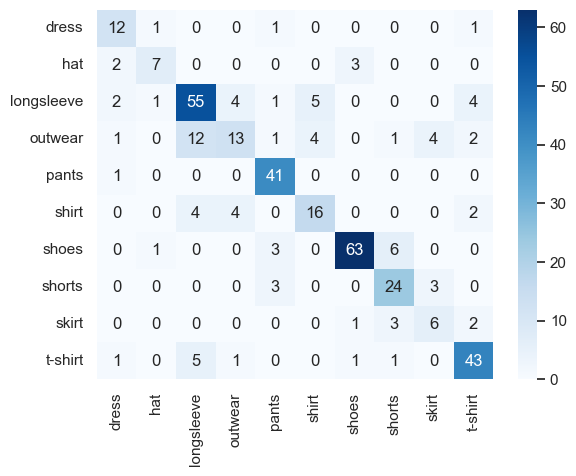

In [39]:
ConfusionMatrix(model, test_ds, test_data.class_names)

In [40]:
# run the model prediction and obtain the probabilities
y_pred = model.predict(test_ds)

# store the list of predicted classes by taking the argmax of the probabilities
predicted_categories = tf.argmax(y_pred, axis = 1)

# extract the list of class names
class_names = test_data.class_names

# create a list of all y's labels by iterating over test dataset
true_categories = tf.concat([y for x, y in test_ds], axis = 0)

# calculate accuracy
from sklearn import metrics

# test accuracy
metrics.accuracy_score(true_categories, predicted_categories) * 100

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


75.26881720430107

Observe that, by adding regularization, the test accuracy has been improved by quite a bit.

# Tackling Overfitting: Modifications In The Data Pipeline (Data Augmentation)

### What is augmentation?
Augmentation is a technique to artificially increase the amount of data by generating new data points from the existing data. The amount of data can be increased by making minor transformations to the current data. By applying transformations, new, slightly modified versions of the original data is generated. This artificially increases the size of the dataset.

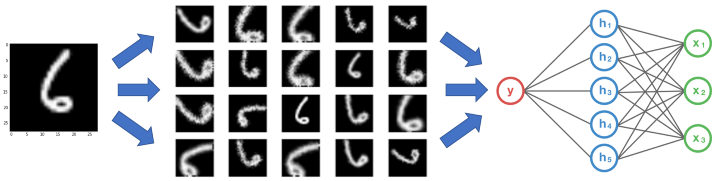

### How does it help with training?
This leads to greater diversity of data samples being seen by the network hence decreasing the likelihood of overfitting the model on he training dataset.

### What are the different types of augmentation techniques that can be applied?
- Flips: Horizontally or vertically flipping the images.
- Rotations: Rotating images by small angles.
- Translations: Shifting images slightly along the x or y both axes.
- Scaling: Zooming in or out slightly.
- Shearing: Skewing the image.
- Brightness or contrast adjustments: Changing the brightness, contrast or color saturation.
- Noise addition: Adding small amounts of random noise.
- Others: Padding, Cropping, Grayscaling, Erasing.

### How is augmentation applied in TensorFlow or Keras?
There are many ways to apply augmentation in TensorFlow or Keras.
1. Using Keras preprocessing layers: Similar to preprocessing functions like `resizing` and `rescaling`, Keras also provides data augmentation layers like `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, etc.
2. Using `tf.image` methods like `tf.image.stateless_random_flip_up_down`, `tf.image.stateless_random_brightness`.
3. Using Keras `ImageDataGenerator` API: It provides a quick, out-of-the-box suite of augmentation techniques like standardization, rotation, shifts, flips, brightness change and many more.

In [44]:
# load the sample
def load_sample(output_size = (300, 300)):
    # sample = tf.keras.utils.get_file("sample.jpg", "https://t3638486.p.clickup-attachments.com/t3638486/a0a4f633-2963-4e06-acae-2ad1d12eba3e/sample.jpg")
    sample = tf.keras.utils.load_img("sample.jpg", target_size = output_size)
    sample = tf.keras.utils.img_to_array(sample)
    return sample

# visualize the sample
def show_images(imgs, num_rows, num_cols, scale = 2):
    aspect_ratio = imgs[0].shape[0]/ imgs[0].shape[1]
    figsize = (num_cols * scale, num_rows * scale * aspect_ratio)
    _, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            if num_rows != 1:
                axes[i][j].imshow(imgs[i * num_cols + j].numpy().astype("uint8"))
                axes[i][j].axes.get_xaxis().set_visible(False)
                axes[i][j].axes.get_yaxis().set_visible(False)
            else:
                plt.imsave("test.png", imgs[i * num_cols + j].numpy()[0].astype("uint8"))
                axes[j].imshow(imgs[i * num_cols +j].numpy().astype("uint8"))
                axes[j].axes.get_xaxis().set_visible(False)
                axes[j].axes.get_yaxis().set_visible(False)
                
    plt.subplots_adjust(hspace = 0.1, wspace = 0)
    return axes

def apply(img, aug, num_rows = 1, num_cols = 4, scale = 3):
    
    y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(y, num_rows, num_cols)

### Basic augmentation techniques using `tf.keras.layers.*` and `tf.image`
All these augmentation techniques will only apply if the mode is set to training.

In [45]:
# the following should be run to reset the mode to training
tf.keras.backend.clear_session()

1. `RandomCrop`: During training, this layer will randomly choose a location to crop images down to a target size. The layer will crop all the images in the same batch to the same cropping location.

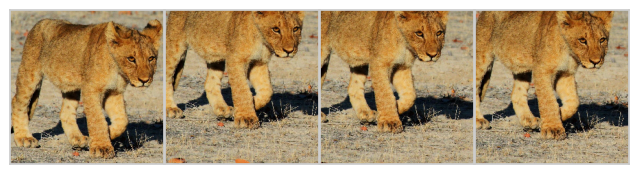

In [46]:
from tensorflow.keras.layers import RandomCrop

sample = load_sample(output_size = (300, 300))
aug_layer = RandomCrop(height = 224, width = 224)
apply(sample, aug_layer)

In [51]:
# alternative implementation using tf.image
random_crop = tf.image.random_crop(value = sample, size = (224, 224, 3))

2. `RandomTranslation`: This layer will apply random translations to each image during training, filling empty space according to `fill_mode`.

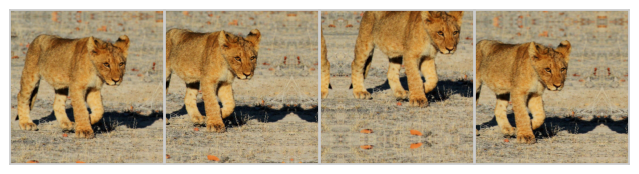

In [49]:
from tensorflow.keras.layers import RandomTranslation

sample = load_sample(output_size = (300, 300))
aug_layer = RandomTranslation(height_factor = (-0.2, 0.3), width_factor = (-0.2, 0.3))
apply(sample, aug_layer)

In [52]:
# alternative implementation using tf.image
random_shift = tf.keras.preprocessing.image.random_shift(sample, hrg = 0.2, wrg = 0.5)

3. `RandomRotation`: This layer will apply random rotations to each image, filling empty space according to `fill_mode`.

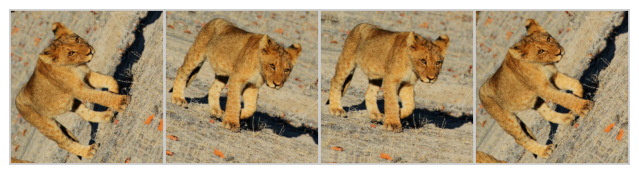

In [53]:
from tensorflow.keras.layers import RandomRotation

sample = load_sample(output_size = (300, 300))
aug_layer = RandomRotation(factor = (-0.2, 0.3))
apply(sample, aug_layer)

In [54]:
# alternative implementation using tf.image
random_rotation = tf.keras.preprocessing.image.random_rotation(sample, rg = 500, channel_axis = 2, row_axis = 0, col_axis = 1)

4. `RandomFlip`: This layers flips the images horizontally or vertically.

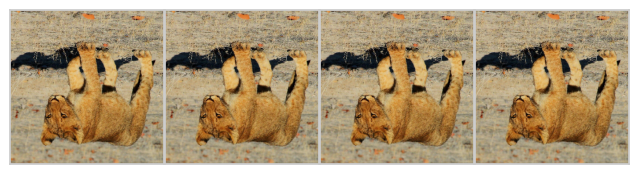

In [55]:
from tensorflow.keras.layers import RandomFlip

sample = load_sample(output_size = (300, 300))
aug_layer = RandomFlip()
apply(sample, aug_layer)

In [56]:
# alternative implementation tf.image
random_flip = tf.image.random_flip_left_right(sample, 10)

5. `RandomBrightness`: This layer will randomly increase or decrease the brightness for the input RGB images.

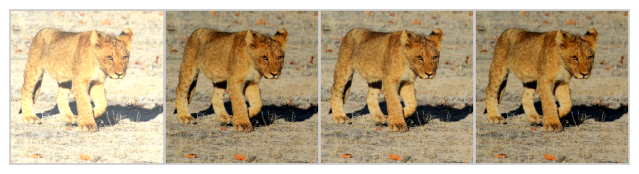

In [57]:
sample = load_sample(output_size = (300, 300))

try:
    from tensorflow.keras.layers import RandomBrightness

    aug_layer = RandomBrightness(factor = (-0.2, 0.5))
except:
    print("This version of TensorFlow does not have tensorflow.keras.layers.RandomBrightness class.")
    print("Using tf.image.random_brightness instead.")
    aug_layer = lambda x: tf.image.random_brightness(x, 100)

apply(sample, aug_layer)

In [58]:
# alternative implementation using if.image
random_brightness = tf.image.random_brightness(sample, 100)

6. `RandomContrast`: This layer will randomly adjust the contrast of an image or images by a random factor. Contrast is adjusted independently for each channel of each image during training.

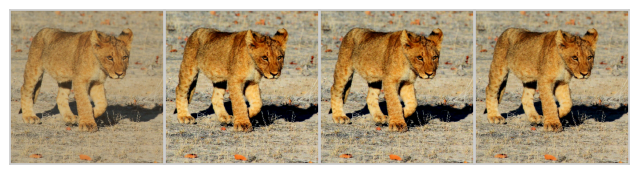

In [59]:
from tensorflow.keras.layers import RandomContrast

sample = load_sample(output_size = (300, 300))
aug_layer = RandomContrast(factor = (0.5, 0.9))
apply(sample, aug_layer)

In [60]:
# alternative implementation using tf.image
random_contrast = tf.image.random_contrast(sample, 0.5, 10)

### Modification 5
Applying the data augmentation techniques on the clothing dataset.